In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from warnings import filterwarnings
filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
diabetes = pd.read_csv("diabetes.csv")
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
BloodPressure,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
Insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
BMI,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [8]:
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]

In [35]:
for feature in df:
    
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3-Q1
    lower = Q1- 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies no
Glucose no
BloodPressure no
SkinThickness yes
Insulin yes
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [ ]:
Q1 = df.Insulin.quantile(0.25)
Q3 = df.Insulin.quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
df.loc[df["Insulin"] > upper,"Insulin"] = upper

In [ ]:
df.corr()

In [10]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [11]:
#statsmodels
loj = sm.Logit(y, X)
loj_model= loj.fit()
loj_model.summary()

Optimization terminated successfully.
         Current function value: 0.561520
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      760
Method:                           MLE   Df Model:                            7
Date:                Wed, 22 Jul 2020   Pseudo R-squ.:                  0.1318
Time:                        14:28:18   Log-Likelihood:                -431.25
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 3.905e-25
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.1289      0.029      4.384      0.000       0.071       0.187
Glucose                      0.0157      0.003      4.816      0.000       0.009       0.022
BloodPressure               -0.0567      0.007     -7.944      0.000      -0.071      -0.043
SkinThickness                0.0204      0.012      1.724      0.085      -0.003       0.044
Insulin                      0.0057      0.001      4.404      0.000       0.003       0.008
BMI                         -0.0101      0.015     -0.666      0.506      -0.040       0.020
DiabetesPedigreeFunction     0.3333      0.257      1.295      0.195      -0.171       0.838
Age                         -0.0038      0.009     -0.420      0.675      -0.021       0.014
============================================================================================
"""

In [12]:

#scikit-learn

from sklearn.linear_model import LogisticRegression
loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(X,y)
loj_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
loj_model.intercept_

array([-5.91487844])

In [14]:
loj_model.coef_

array([[ 0.11338684,  0.02441809, -0.02026553,  0.0295512 ,  0.00521104,
         0.03514231,  0.54524119,  0.00716963]])

In [15]:
#Tahmin & Model Tuning

In [16]:
y_pred = loj_model.predict(X)

In [17]:
confusion_matrix(y, y_pred)

array([[445,  55],
       [116, 152]])

In [18]:
accuracy_score(y, y_pred)

0.77734375

In [19]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       500
           1       0.73      0.57      0.64       268

    accuracy                           0.78       768
   macro avg       0.76      0.73      0.74       768
weighted avg       0.77      0.78      0.77       768



In [20]:
loj_model.predict(X)[0:10]

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0])

In [21]:
loj_model.predict_proba(X)[0:10][:,0:2]

array([[0.32763647, 0.67236353],
       [0.91084032, 0.08915968],
       [0.19666207, 0.80333793],
       [0.92871888, 0.07128112],
       [0.17824716, 0.82175284],
       [0.81134223, 0.18865777],
       [0.86624194, 0.13375806],
       [0.63134647, 0.36865353],
       [0.03226269, 0.96773731],
       [0.58736094, 0.41263906]])

In [22]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

In [23]:
y_probs = loj_model.predict_proba(X)
y_probs = y_probs[:,1]

In [24]:
y_probs[0:10]

array([0.67236353, 0.08915968, 0.80333793, 0.07128112, 0.82175284,
       0.18865777, 0.13375806, 0.36865353, 0.96773731, 0.41263906])

In [25]:
y_pred = [1 if i > 0.5 else 0 for i in y_probs]

In [26]:
y_pred[0:10]

[1, 0, 1, 0, 1, 0, 0, 0, 1, 0]

In [27]:
confusion_matrix(y, y_pred)

array([[445,  55],
       [116, 152]])

In [28]:
accuracy_score(y, y_pred)

0.77734375

In [29]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       500
           1       0.73      0.57      0.64       268

    accuracy                           0.78       768
   macro avg       0.76      0.73      0.74       768
weighted avg       0.77      0.78      0.77       768



In [30]:
loj_model.predict_proba(X)[:,1][0:5]

array([0.67236353, 0.08915968, 0.80333793, 0.07128112, 0.82175284])

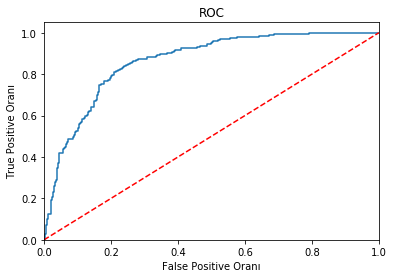

In [31]:
logit_roc_auc = roc_auc_score(y, loj_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, loj_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Oranı')
plt.ylabel('True Positive Oranı')
plt.title('ROC')
plt.show()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.30, 
                                                    random_state = 42)



In [33]:
loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(X_train,y_train)
loj_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
accuracy_score(y_test, loj_model.predict(X_test))

0.7532467532467533

In [65]:
cross_val_score(loj_model, X_test, y_test, cv = 10).mean()

0.6863636363636363

In [ ]:
#Gaussian Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

In [38]:
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)
nb_model

GaussianNB(priors=None, var_smoothing=1e-09)

In [39]:
nb_model.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [40]:
nb_model.predict_proba(X_test)[0:10]

array([[7.81769176e-01, 2.18230824e-01],
       [9.45779839e-01, 5.42201607e-02],
       [9.87218781e-01, 1.27812192e-02],
       [8.92020831e-01, 1.07979169e-01],
       [5.02584044e-01, 4.97415956e-01],
       [4.44724194e-01, 5.55275806e-01],
       [9.99632121e-01, 3.67878815e-04],
       [7.97349046e-01, 2.02650954e-01],
       [5.44616944e-01, 4.55383056e-01],
       [2.78176610e-01, 7.21823390e-01]])

In [41]:
y_pred = nb_model.predict(X_test)

In [42]:
accuracy_score(y_test, y_pred)

0.7445887445887446

In [43]:
cross_val_score(nb_model, X_test, y_test, cv = 10).mean()

0.7619565217391304

**KNN
Model & Tahmin**

In [50]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
knn_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


In [45]:
y_pred = knn_model.predict(X_test)

In [46]:
accuracy_score(y_test, y_pred)

0.8311688311688312

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       151
           1       0.75      0.78      0.76        80

    accuracy                           0.83       231
   macro avg       0.81      0.82      0.82       231
weighted avg       0.83      0.83      0.83       231



In [48]:
#Model Tuning

In [51]:
knn_params = {"n_neighbors": np.arange(1,50)}

In [52]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
print("En iyi skor:" + str(knn_cv.best_score_))
print("En iyi parametreler: " + str(knn_cv.best_params_))

En iyi skor:0.8772536687631028
En iyi parametreler: {'n_neighbors': 6}


In [58]:
knn = KNeighborsClassifier(11)
knn_tuned = knn.fit(X_train, y_train)

In [59]:
knn_tuned.score(X_test, y_test)

0.8441558441558441

In [60]:
y_pred = knn_tuned.predict(X_test)

In [61]:
accuracy_score(y_test, y_pred)

0.8441558441558441

**SVC
Model & Tahmin**

In [62]:
svm_model = SVC(kernel = "linear").fit(X_train, y_train)

In [63]:
svm_model

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
y_pred = svm_model.predict(X_test)

In [65]:
accuracy_score(y_test, y_pred)

0.7619047619047619

In [66]:
#Model Tuning¶

In [67]:
svc_params = {"C": np.arange(1,10)}

svc = SVC(kernel = "linear")

svc_cv_model = GridSearchCV(svc,svc_params, 
                            cv = 10, 
                            n_jobs = -1, 
                            verbose = 2 )

svc_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.2min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [68]:
print("En iyi parametreler: " + str(svc_cv_model.best_params_))

En iyi parametreler: {'C': 5}


In [69]:
svc_tuned = SVC(kernel = "linear", C = 5).fit(X_train, y_train)

In [70]:
y_pred = svc_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.7489177489177489

**RBF SVC
Model & Tahmin**



In [71]:
svc_model = SVC(kernel = "rbf").fit(X_train, y_train)

In [72]:
svc_model

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [73]:
y_pred = svc_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8311688311688312

In [75]:
#Model Tuning

In [76]:
svc_params = {"C": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
             "gamma": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100]}

In [77]:
svc = SVC()
svc_cv_model = GridSearchCV(svc, svc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

svc_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    6.3s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [78]:
print("En iyi parametreler: " + str(svc_cv_model.best_params_))

En iyi parametreler: {'C': 10, 'gamma': 0.0001}


In [79]:
svc_tuned = SVC(C = 10, gamma = 0.0001).fit(X_train, y_train)

In [80]:
y_pred = svc_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8658008658008658

**Yapay Sinir Ağları**
**Model & Tahmin**


In [81]:
from sklearn.preprocessing import StandardScaler  

In [82]:
scaler = StandardScaler()

In [83]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
X_test_scaled[0:5]

array([[ 0.69748316, -0.79493621, -1.1655593 ,  0.49576916,  0.54064987,
         0.24942794, -0.11680393,  0.85019217],
       [-0.52953881, -0.33061095,  0.22780034,  0.37905366, -0.44248779,
         0.49363941, -0.94192338, -1.03426754],
       [-0.52953881, -0.46327531, -0.67378531, -0.20452379, -0.44248779,
        -0.21026422, -0.91266382, -1.03426754],
       [ 1.31099414, -0.4964414 ,  0.63761199, -0.20452379, -0.44248779,
        -1.1009178 ,  1.12965312,  0.07927683],
       [ 1.00423865,  0.46537521,  1.45723531, -0.20452379, -0.44248779,
        -0.33955265, -0.76051413,  1.44979298]])

In [85]:
from sklearn.neural_network import MLPClassifier

In [86]:
mlpc = MLPClassifier().fit(X_train_scaled, y_train)

In [87]:
y_pred = mlpc.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.8311688311688312

In [88]:
#Model Tuning

In [89]:
mlpc

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [90]:
mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005, 0.0001,0.00001],
              "hidden_layer_sizes": [(10,10,10),
                                     (100,100,100),
                                     (100,100),
                                     (3,5), 
                                     (5, 3)],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": ["relu","logistic"]}



In [91]:
mlpc = MLPClassifier()
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

mlpc_cv_model.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 369 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 652 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1017 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1462 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 13.6min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_stat...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.1, 0.01, 

In [92]:
print("En iyi parametreler: " + str(mlpc_cv_model.best_params_))

En iyi parametreler: {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (10, 10, 10), 'solver': 'adam'}


In [93]:
mlpc_tuned = MLPClassifier(activation = "logistic", 
                           alpha = 0.1, 
                           hidden_layer_sizes = (100, 100, 100),
                          solver = "adam")

In [94]:
mlpc_tuned.fit(X_train_scaled, y_train)

MLPClassifier(activation='logistic', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [95]:
y_pred = mlpc_tuned.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.7965367965367965

**CART
Model & Tahmin**

In [96]:
from sklearn.tree import DecisionTreeClassifier

In [97]:
cart = DecisionTreeClassifier()
cart_model = cart.fit(X_train, y_train)

In [98]:
cart_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [122]:
!pip install skompiler
!pip install astor
from skompiler import skompile
print(skompile(cart_model.predict).to("python/code"))


((((((((0 if x[6] <= 0.6754999756813049 else (1 if x[3] <= 13.5 else 0) if 
    x[4] <= 90.0 else 1) if x[4] <= 95.5 else 1) if x[1] <= 127.0 else 0 if
    x[5] <= 27.300000190734863 else 1) if x[4] <= 98.0 else 0) if x[1] <= 
    154.5 else (0 if x[4] <= 80.0 else 1) if x[7] <= 40.0 else 0) if x[5] <=
    50.85000038146973 else 1) if x[4] <= 109.0 else ((0 if x[0] <= 4.5 else
    1 if x[7] <= 27.5 else 0) if x[0] <= 7.5 else 1) if x[1] <= 124.5 else 
    ((0 if x[7] <= 36.5 else 1) if x[1] <= 127.0 else 0 if x[2] <= 63.0 else
    1) if x[4] <= 132.5 else 1 if x[0] <= 3.0 else 0) if x[4] <= 143.0 else
    ((0 if x[5] <= 30.300000190734863 else (0 if x[3] <= 29.5 else 1) if x[
    1] <= 127.5 else (1 if x[0] <= 0.5 else 0) if x[3] <= 24.0 else 1) if x
    [3] <= 30.5 else (0 if x[4] <= 158.5 else 1) if x[4] <= 169.75 else (1 if
    x[2] <= 55.0 else 0 if x[5] <= 41.44999885559082 else 1 if x[7] <= 25.0
     else 0) if x[1] <= 169.0 else 1) if x[7] <= 28.5 else ((1 if x[5] <= 
    31.600

In [123]:
x = [9]

In [126]:
0 if x[0] <= 2.5 else 0 if x[0] <= 6.5 else 1 if x[0] <= 13.5 else 1

1

In [127]:
y_pred = cart_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8311688311688312

In [ ]:
#Model Tuning

In [128]:
cart_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [129]:
cart_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50)) }

In [130]:
cart = tree.DecisionTreeClassifier()
cart_cv = GridSearchCV(cart, cart_grid, cv = 10, n_jobs = -1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1772 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:   14.6s finished


In [131]:
print("En iyi parametreler: " + str(cart_cv_model.best_params_))

En iyi parametreler: {'max_depth': 5, 'min_samples_split': 14}


In [ ]:
#final

In [132]:
cart = tree.DecisionTreeClassifier(max_depth = 5, min_samples_split = 19)
cart_tuned = cart.fit(X_train, y_train)

In [133]:
y_pred = cart_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8614718614718615

# Random Forests

In [134]:
from sklearn.ensemble import RandomForestClassifier

In [135]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

In [136]:
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
#Model Tuning

In [137]:
rf_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [138]:
?rf_model

Type:        RandomForestClassifier
String form:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
           c <...> obs=None, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Length:      100
File:        /opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py
Docstring:  
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is always the same as the original
input sample size but the samples are drawn with replacement if
`bootstrap=True` (default).

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : integer, optional (default=100)
    The number of trees in the forest.

    .. versionchanged:: 0.22
       The default value of ``n_estimators`` changed from 10 to 100
       in 0.22.

criterion :

In [139]:
rf_params = {"max_depth": [2,5,8,10],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

In [140]:
rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2) 

In [141]:
rf_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 369 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 652 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1017 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 13.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [142]:
print("En iyi parametreler: " + str(rf_cv_model.best_params_))

En iyi parametreler: {'max_depth': 8, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 500}


In [143]:
#final

In [144]:
rf_tuned = RandomForestClassifier(max_depth = 10, 
                                  max_features = 8, 
                                  min_samples_split = 10,
                                  n_estimators = 1000)

rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [145]:
y_pred = rf_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8658008658008658

In [146]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

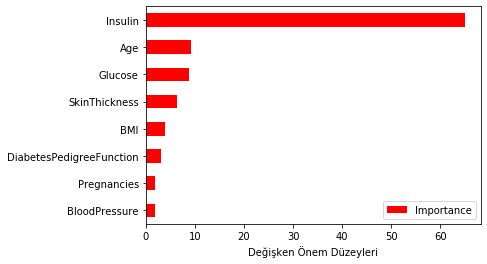

In [147]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

# GBM

In [148]:
from sklearn.ensemble import GradientBoostingClassifier

In [149]:
gbm_model = GradientBoostingClassifier().fit(X_train, y_train)

In [150]:
y_pred = gbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8701298701298701

In [151]:
# Model Tuning


In [152]:
gbm_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [153]:
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}

In [154]:
gbm = GradientBoostingClassifier()

gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)

In [155]:
gbm_cv.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  6.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_...
                 

In [156]:
print("En iyi parametreler: " + str(gbm_cv.best_params_))

En iyi parametreler: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}


In [157]:
gbm = GradientBoostingClassifier(learning_rate = 0.01, 
                                 max_depth = 3,
                                min_samples_split = 5,
                                n_estimators = 500)

In [158]:
gbm_tuned =  gbm.fit(X_train,y_train)

In [159]:
y_pred = gbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8744588744588745

# XGBoost

In [160]:
#!pip install xgboost
from xgboost import XGBClassifier

In [161]:
xgb_model = XGBClassifier().fit(X_train, y_train)

In [162]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [163]:
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8744588744588745

In [164]:
# Model Tuning

In [165]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [166]:
xgb_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_samples_split": [2,5,10]}

In [167]:
xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)

In [168]:
xgb_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1037 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1482 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2009 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2616 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 3305 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 4074 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 4925 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 34.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10],
 

In [169]:
xgb_cv_model.best_params_

{'learning_rate': 0.02,
 'max_depth': 3,
 'min_samples_split': 2,
 'n_estimators': 500,
 'subsample': 1.0}

In [170]:
xgb = XGBClassifier(learning_rate = 0.01, 
                    max_depth = 6,
                    min_samples_split = 2,
                    n_estimators = 100,
                    subsample = 0.8)

In [171]:
xgb_tuned =  xgb.fit(X_train,y_train)

In [172]:
y_pred = xgb_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8658008658008658

# LightGBM

In [173]:
from lightgbm import LGBMClassifier

In [174]:
lgbm_model = LGBMClassifier().fit(X_train, y_train)

In [175]:
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8701298701298701

In [176]:
# Model Tuning

In [177]:
lgbm_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [178]:
lgbm_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_child_samples": [5,10,20]}

In [179]:
lgbm = LGBMClassifier()

lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, 
                             cv = 10, 
                             n_jobs = -1, 
                             verbose = 2)



In [180]:
lgbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1061 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1506 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2033 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2640 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 3329 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 4098 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 4949 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed: 19.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'ma

In [181]:
lgbm_cv_model.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_samples': 5,
 'n_estimators': 500,
 'subsample': 0.6}

In [182]:
lgbm = LGBMClassifier(learning_rate = 0.01, 
                       max_depth = 3,
                       subsample = 0.6,
                       n_estimators = 500,
                       min_child_samples = 20)

In [183]:
lgbm_tuned = lgbm.fit(X_train,y_train)

In [184]:
y_pred = lgbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8701298701298701

In [185]:
# CatBoost

In [186]:
#Model & Tahmin

In [187]:
#!pip install catboost
from catboost import CatBoostClassifier

In [188]:
cat_model = CatBoostClassifier().fit(X_train, y_train)

Learning rate set to 0.0079
0:	learn: 0.6860593	total: 66.7ms	remaining: 1m 6s
1:	learn: 0.6787808	total: 69.1ms	remaining: 34.5s
2:	learn: 0.6727670	total: 72.4ms	remaining: 24.1s
3:	learn: 0.6654203	total: 75ms	remaining: 18.7s
4:	learn: 0.6583796	total: 77.3ms	remaining: 15.4s
5:	learn: 0.6507944	total: 79.6ms	remaining: 13.2s
6:	learn: 0.6431850	total: 82ms	remaining: 11.6s
7:	learn: 0.6347761	total: 84.4ms	remaining: 10.5s
8:	learn: 0.6299454	total: 86.6ms	remaining: 9.54s
9:	learn: 0.6227784	total: 89.3ms	remaining: 8.84s
10:	learn: 0.6160659	total: 91.7ms	remaining: 8.25s
11:	learn: 0.6103778	total: 94.1ms	remaining: 7.75s
12:	learn: 0.6044539	total: 96.5ms	remaining: 7.33s
13:	learn: 0.5987503	total: 98.9ms	remaining: 6.97s
14:	learn: 0.5917562	total: 101ms	remaining: 6.66s
15:	learn: 0.5840288	total: 104ms	remaining: 6.37s
16:	learn: 0.5785449	total: 106ms	remaining: 6.12s
17:	learn: 0.5735703	total: 108ms	remaining: 5.89s
18:	learn: 0.5682509	total: 110ms	remaining: 5.69s
19:

In [189]:
y_pred = cat_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8614718614718615

In [ ]:
#modeltuning

In [190]:
catb_params = {
    'iterations': [200,500],
    'learning_rate': [0.01,0.05, 0.1],
    'depth': [3,5,8] }

In [191]:
catb = CatBoostClassifier()
catb_cv_model = GridSearchCV(catb, catb_params, cv=5, n_jobs = -1, verbose = 2)
catb_cv_model.fit(X_train, y_train)
catb_cv_model.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   52.1s finished


0:	learn: 0.6339802	total: 1.22ms	remaining: 243ms
1:	learn: 0.5696357	total: 2.6ms	remaining: 258ms
2:	learn: 0.5198928	total: 3.8ms	remaining: 249ms
3:	learn: 0.4768667	total: 4.94ms	remaining: 242ms
4:	learn: 0.4443025	total: 6.08ms	remaining: 237ms
5:	learn: 0.4096408	total: 7.43ms	remaining: 240ms
6:	learn: 0.3904734	total: 8.67ms	remaining: 239ms
7:	learn: 0.3656117	total: 9.84ms	remaining: 236ms
8:	learn: 0.3539201	total: 11ms	remaining: 233ms
9:	learn: 0.3405689	total: 12.1ms	remaining: 231ms
10:	learn: 0.3252763	total: 13.3ms	remaining: 229ms
11:	learn: 0.3191188	total: 14.7ms	remaining: 230ms
12:	learn: 0.3106900	total: 16.2ms	remaining: 233ms
13:	learn: 0.3011487	total: 17.7ms	remaining: 235ms
14:	learn: 0.2886159	total: 19.4ms	remaining: 240ms
15:	learn: 0.2823725	total: 21ms	remaining: 242ms
16:	learn: 0.2782155	total: 22.6ms	remaining: 243ms
17:	learn: 0.2752574	total: 23.8ms	remaining: 240ms
18:	learn: 0.2712874	total: 24.9ms	remaining: 237ms
19:	learn: 0.2658815	total: 

{'depth': 3, 'iterations': 200, 'learning_rate': 0.1}

In [192]:
catb_cv_model.best_params_

{'depth': 3, 'iterations': 200, 'learning_rate': 0.1}

In [193]:
catb = CatBoostClassifier(iterations = 200, 
                          learning_rate = 0.05, 
                          depth = 5)

catb_tuned = catb.fit(X_train, y_train)
y_pred = catb_tuned.predict(X_test)

0:	learn: 0.6502187	total: 4.04ms	remaining: 803ms
1:	learn: 0.6159221	total: 8.37ms	remaining: 829ms
2:	learn: 0.5775301	total: 11.5ms	remaining: 754ms
3:	learn: 0.5454495	total: 14.3ms	remaining: 700ms
4:	learn: 0.5145079	total: 16.4ms	remaining: 640ms
5:	learn: 0.4893862	total: 19ms	remaining: 616ms
6:	learn: 0.4598527	total: 21.7ms	remaining: 598ms
7:	learn: 0.4361147	total: 24.2ms	remaining: 582ms
8:	learn: 0.4196340	total: 26.3ms	remaining: 558ms
9:	learn: 0.4048202	total: 28.6ms	remaining: 543ms
10:	learn: 0.3874543	total: 31.2ms	remaining: 536ms
11:	learn: 0.3728241	total: 33.4ms	remaining: 523ms
12:	learn: 0.3616296	total: 35.7ms	remaining: 514ms
13:	learn: 0.3466688	total: 39.2ms	remaining: 520ms
14:	learn: 0.3349312	total: 41.7ms	remaining: 514ms
15:	learn: 0.3226848	total: 44ms	remaining: 506ms
16:	learn: 0.3156807	total: 46.1ms	remaining: 496ms
17:	learn: 0.3094928	total: 48.4ms	remaining: 489ms
18:	learn: 0.3009116	total: 50.8ms	remaining: 484ms
19:	learn: 0.2915729	total

In [194]:
y_pred = catb_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8571428571428571

# Karşılaştırılma

In [195]:
modeller = [
    knn_tuned,
    loj_model,
    svc_tuned,
    nb_model,
    mlpc_tuned,
    cart_tuned,
    rf_tuned,
    gbm_tuned,
    catb_tuned,
    lgbm_tuned,
    xgb_tuned
    
]


for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)
    print("-"*28)
    print(isimler + ":" )
    print("Accuracy: {:.4%}".format(dogruluk))

----------------------------
KNeighborsClassifier:
Accuracy: 84.4156%
----------------------------
LogisticRegression:
Accuracy: 75.3247%
----------------------------
SVC:
Accuracy: 86.5801%
----------------------------
GaussianNB:
Accuracy: 74.4589%
----------------------------
MLPClassifier:
Accuracy: 34.6320%
----------------------------
DecisionTreeClassifier:
Accuracy: 86.1472%
----------------------------
RandomForestClassifier:
Accuracy: 86.5801%
----------------------------
GradientBoostingClassifier:
Accuracy: 87.4459%
----------------------------
CatBoostClassifier:
Accuracy: 85.7143%
----------------------------
LGBMClassifier:
Accuracy: 87.0130%
----------------------------
XGBClassifier:
Accuracy: 86.5801%


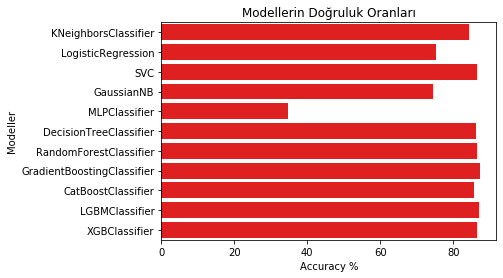

In [196]:
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)
    
    
sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Accuracy %')
plt.title('Modellerin Doğruluk Oranları');    